# ESM Temperature profile mask
The purpose of this notebook is to create a mask to remove all land based data points and Nans at a depth of 2000 m from the ESM3 temperature data from historic simulations. To do this the notebook takes imports a prior mask calculated in v1.0.

The [mask calculation and creation](#Calculating-the-mask) can be found in the bottom half of the document.

#### Dask Import

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:39675")
client

Client Scheduler: tcp://127.0.0.1:39675 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 6 Cores: 6 Memory: 38.65 GB


<br>

#### Choices for data

In [2]:
#Experiment data for analysis
dataVariableId = 'thetao'
dataExperimentId = 'historical'
dataSourceID = 'E3SM-1-0'

#Ocean Area data for averaging
areaActivityId = 'CMIP'
areaVariableId = 'volcello'
areaSourceId = 'E3SM-1-0'
areaDataSetNo = 0 #First database in results to be used

#Custom Variables
importMaskName = "OceanMaskVolcello2"
idSel = 0 #Run Id selection
latSel = slice(-89.5,-29.5) #Selected latitude to be investigated
levSel = slice(1900, 2000)
timeSel = slice("2005-01","2014-12")

<br>

#### Imports

In [3]:
import cartopy.crs as ccrs
import dask.dataframe as dd
import fsspec
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import zarr

from dask import delayed
from matplotlib.pyplot import cm
from math import isnan
print("Imports complete")

Imports complete


<br>

#### Accessing Dataset Database

In [4]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
print("Database accessed")

Database accessed


<br>

#### Filtering for relevant data sets
ESM3 data sets

In [5]:
dfFilt = df[df.variable_id.eq(dataVariableId) & df.experiment_id.eq(dataExperimentId) & df.source_id.eq(dataSourceID)]
print(str(len(dfFilt))+" datasets found.")
dfFilt

5 datasets found.


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
271350,CMIP,E3SM-Project,E3SM-1-0,historical,r1i1p1f1,Omon,thetao,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20190826
272064,CMIP,E3SM-Project,E3SM-1-0,historical,r2i1p1f1,Omon,thetao,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20190830
401970,CMIP,E3SM-Project,E3SM-1-0,historical,r3i1p1f1,Omon,thetao,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20200129
401972,CMIP,E3SM-Project,E3SM-1-0,historical,r4i1p1f1,Omon,thetao,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20200129
431250,CMIP,E3SM-Project,E3SM-1-0,historical,r5i1p1f1,Omon,thetao,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20200429


<br>
Ocean area data to be used for averaging

In [6]:
dfArea = df[df.activity_id.eq(areaActivityId) & df.variable_id.eq(areaVariableId) & df.source_id.eq(areaSourceId)]
print(str(len(dfArea))+" datasets found.")
dfArea.head()

4 datasets found.


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
504530,CMIP,E3SM-Project,E3SM-1-0,historical,r1i1p1f1,Omon,volcello,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20210127
504538,CMIP,E3SM-Project,E3SM-1-0,piControl,r1i1p1f1,Omon,volcello,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/pi...,NaN,20210127
504544,CMIP,E3SM-Project,E3SM-1-0,historical,r5i1p1f1,Omon,volcello,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20210128
504546,CMIP,E3SM-Project,E3SM-1-0,historical,r4i1p1f1,Omon,volcello,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20210128


<br>

#### Opening all datafiles
ESM3 data

In [7]:
fileSetList = []
for i in range(len(dfFilt)):
    zstore = dfFilt.zstore.values[i]
    mapper = fsspec.get_mapper(zstore)
    fileRaw = xr.open_zarr(mapper, consolidated=True)
    fileSetList.append(fileRaw)
fileCount = len(fileSetList)
if fileCount:
    print(str(fileCount)+" ESM3 data sets opened and stored in fileSetList.")
else:
    print("No ESM3 data sets opened")

5 ESM3 data sets opened and stored in fileSetList.


<br>
Ocean Area data

In [8]:
dsArea = xr.open_zarr(fsspec.get_mapper(dfArea.zstore.values[areaDataSetNo]), consolidated=True)
print("Ocean Area data loaded and stored in dsArea")

Ocean Area data loaded and stored in dsArea


<br>
Previously generated ocean mask

In [9]:
maskFile = xr.open_dataset(importMaskName)
oceanMaskImport = maskFile.to_array()
print("Previously generated mask imported and stored in oceanMaskImport.")

Previously generated mask imported and stored in oceanMaskImport.


<br>

#### Combine data sets into one xarray

In [10]:
for i in range(fileCount): #Formatting dates into np.datetime64 format
    startDateIterate = np.datetime64(fileSetList[i]['time'].values[0],'M')
    endDateIterate = np.datetime64(fileSetList[i]['time'].values[-1],'M') + np.timedelta64(1,'M')
    fileSetList[i]['time']=('time', np.arange(startDateIterate, endDateIterate, dtype='datetime64[M]'))
    fileSetList[i]['time_bnds']=('time_bnds', np.arange(startDateIterate, endDateIterate, dtype='datetime64[M]')) 
fileSet = xr.combine_nested(fileSetList, concat_dim='RunID') #Combining data sets
print("ESM data sets successfully merged from fileSetList into fileSet.")
#fileSet #Uncomment to see full data set

ESM data sets successfully merged from fileSetList into fileSet.


<br>

#### Selection of Data

In [11]:
dataFiltFull = fileSet.thetao.sel(lat=latSel, lev=levSel, RunID=idSel, time=timeSel) #Selection of latitude, level, run and time
dataFiltFull = dataFiltFull.sel(lev=dataFiltFull.lev.values[0])
dataFiltFullM = dataFiltFull.mean("time", keep_attrs=True) #Dimension reduction by taking average over time
dataFiltFull = dataFiltFull.reset_coords(drop=True)
dataFiltFullM = dataFiltFullM.reset_coords(drop=True) 

dataAreaLevFilt = dsArea.volcello.sel(lat=latSel, lev=levSel)
dataAreaLevFilt = dataAreaLevFilt.reset_coords(drop=True)

print("Finished data selection, ESM data filtered and stored in dataFiltFullM, volcello data filtered and stored in dataAreaLevFilt.\nUnaveraged ESM is stored in dataFiltFull.")
#dataFiltFullM #Uncomment to see filtered data set

Finished data selection, ESM data filtered and stored in dataFiltFullM, volcello data filtered and stored in dataAreaLevFilt.
Unaveraged ESM is stored in dataFiltFull.


<br>

#### Time identification

In [12]:
globalStartDate = dataFiltFull["time"][0].values
globalDateInc = dataFiltFull["time"][1].values - globalStartDate
#np.datetime64(globalDateInc,'D')
globalEndDateIn = dataFiltFull["time"][-1].values
globalEndDateOut = globalEndDateIn + globalDateInc

globalStartDateStr = str(globalStartDate)[:7]
globalEndDateInStr = str(globalEndDateIn)[:7]
globalEndDateOutStr = str(globalEndDateOut)[:7]

print("Data start date: "+globalStartDateStr)
print("Data end date (included): "+str(globalEndDateInStr))
print("Data end date (excluded): "+str(globalEndDateOutStr))
print("Data increments in steps of "+str(globalDateInc))

Data start date: 2005-01
Data end date (included): 2014-12
Data end date (excluded): 2015-01
Data increments in steps of 2678400000000000 nanoseconds


<br>

#### Calculation
<b>Functions:</b><br>
convertToOne - Takes an input data set and returns a same dimensioned data set with values (int) 1 for all non Nan values (maximum input value magnitude 10^14). Is a delayed type.<br>
maskCalc - takes an input data set and returns a (int) 1 and "Nan" mask.<br>

In [13]:
@delayed
def convertToOne(dataSet):
    '''Takes in given dataSet and returns values of (int) 1 for all non Nan values (10^14 max value)'''
    dataSetModify = dataSet.copy()
    dataSetModify.values = dataSetModify.values/100000000000000 + 1
    dataSetModify = dataSetModify.astype(int)
    return dataSetModify


def maskCalc(LocData, plotNo):
    '''Takes in a given data set and returns a data set of (int) 1 and Nan matching initial data set.'''
    mask = convertToOne(LocData)
    mask = mask.compute()
    maskNan = mask.where(mask.values == 1)
    return maskNan

print("Calculation functions defined")

Calculation functions defined


<br>

#### Plotting functions
<b>Functions</b> <br>
mapPlot - plots the Southern Ocean orthographic project of the input data set, with input title and figure number <br>

In [14]:
def mapPlot(dataSet, title, plotNo):
    '''Displays given data set on a map'''
    plt.figure(plotNo, figsize= (7,7))
    p=dataSet.plot(x='lon',y='lat',transform=ccrs.PlateCarree(),
    subplot_kws={'projection': ccrs.SouthPolarStereo()})
    p.axes.gridlines()
    p.axes.coastlines()
    plt.title(str(title))

print("Plotting functions defined")

Plotting functions defined


<br>

#### Calculating the mask

<b>Creating the mask</b><br>
Combining the filtered data with the imported mask

In [15]:
maskDataESM = dataFiltFullM.copy()
maskDataESMM = maskDataESM * oceanMaskImport
maskDataESMM = maskDataESMM.rename({"variable":"cleanMe"})
maskDataESMM = maskDataESMM.sel(cleanMe = maskDataESMM.cleanMe.values[0])
maskDataESMM = maskDataESMM.reset_coords(drop=True)
print("Depth data from ESM masked (imported mask oceanMaskImport) and stored in maskDataESM.")
maskDataESMM

Depth data from ESM masked (imported mask oceanMaskImport) and stored in maskDataESM.


<xarray.DataArray (lat: 61, lon: 360)>
dask.array<getitem, shape=(61, 360), dtype=float64, chunksize=(61, 360), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 ... -32.5 -31.5 -30.5 -29.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5

<br>
<b>Calculating the mask</b><br>

In [16]:
oceanMaskESM = maskCalc(maskDataESMM, 1)
print("Ocean mask calculated")

Ocean mask calculated


<br>
<b>Plotting volcello data and the created mask</b><br>

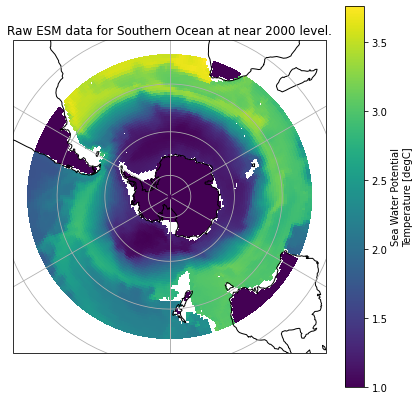

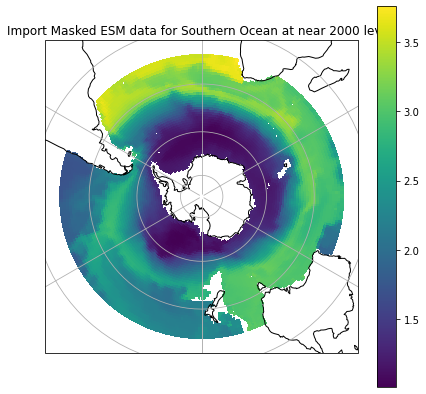

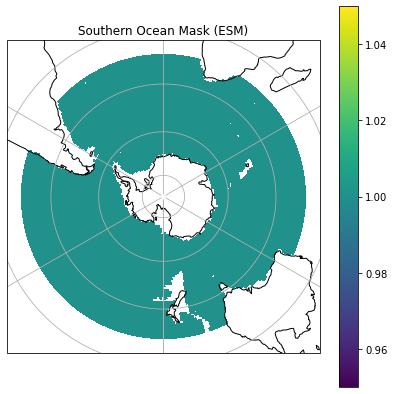

In [17]:
mapPlot(maskDataESM, "Raw ESM data for Southern Ocean at near 2000 level.", 1)
mapPlot(maskDataESMM, "Import Masked ESM data for Southern Ocean at near 2000 level.", 2)
mapPlot(oceanMaskESM, "Southern Ocean Mask (ESM)", 3)

<br>

#### Mask comparison

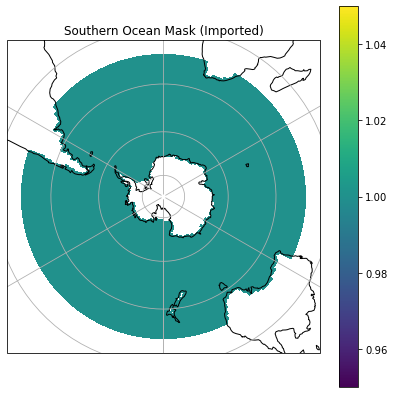

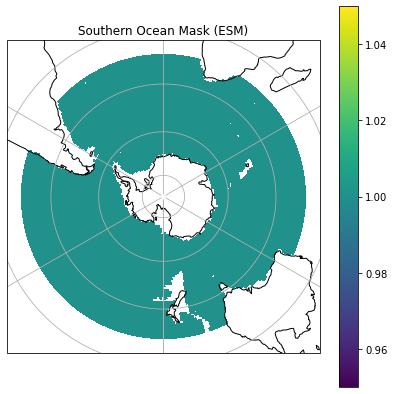

In [18]:
mapPlot(oceanMaskImport, "Southern Ocean Mask (Imported)", 1)
mapPlot(oceanMaskESM, "Southern Ocean Mask (ESM)", 2)

<br>

#### Saving and reloading the mask
<b>Saving the mask</b><br>

In [19]:
maskName = "OceanMaskESM3"
oceanMaskESM.to_netcdf(maskName)
print("Mask saved")

Mask saved


<br>
<b>Reloading the mask</b><br>

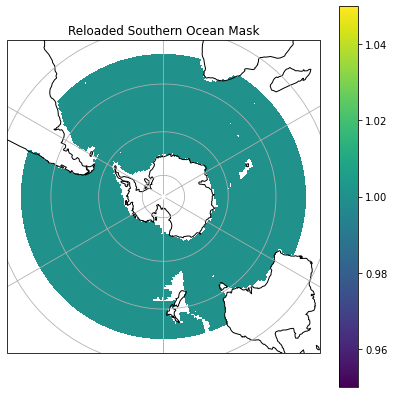

In [20]:
maskFile = xr.open_dataset(maskName)
oceanMaskReload = maskFile.to_array()
mapPlot(oceanMaskReload, "Reloaded Southern Ocean Mask", 1)

<br>
<b>Checking mask dimensions</b>

In [21]:
print("Exported mask dims: ", oceanMaskESM.dims)
print("Loaded mask dims: ", oceanMaskReload.dims)

Exported mask dims:  ('lat', 'lon')
Loaded mask dims:  ('variable', 'lat', 'lon')


<br>